In [1]:
%load_ext autoreload
%autoreload 2
%aimport hpt_cmp

%matplotlib inline

In [130]:
import dataset_loader as ds
import model_loader as mdl
import seaborn as sns

from hpt_cmp import *

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score ,make_scorer
from tqdm import tqdm_notebook, tnrange
from skopt.space import Real, Integer, Categorical

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# LOAD DATASETS
ds_names = ['iris', 'wine', 'breast_cancer', 'digits']
datasets = {}

for name in ds_names:
    datasets[name]=(ds.load(name))
    

In [48]:
dsBunch = datasets['digits']
data = (dsBunch.data, dsBunch.target)
n_features = dsBunch.data.shape[1]
n_features

64

In [49]:
# define param grid

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]
#BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier

pg = {
    'n_estimators': grid_n_estimator, #default=10
    'max_samples': grid_ratio, #default=1.0
    'random_state': grid_seed
}
hg = {
    'n_estimators': hp.choice('n_estimators',grid_n_estimator), #default=10
    'max_samples': hp.choice('max_samples',grid_ratio), #default=1.0
    'random_state': hp.choice('random_state',grid_seed)
}
bg = {
    'n_estimators': Integer(10, 300), #default=10
    'max_samples': Real(0.1, 1.0), #default=1.0
    'random_state': [0]
}
base = {
    'n_estimators': 10, #default=10
    'max_samples': 1.0, #default=1.0
    'random_state': 0
}

In [50]:
BC = {
    'model': ensemble.BaggingClassifier,
    'hpt_objs': [
        ('Base', base, run_baseline, {}),
        ('GS', pg, grid_search, {}),
        ('RS', pg, random_search, {'n_iter':MAX_ITER}),
        ('BS', bg, baysian_search, {'n_iter':MAX_ITER}),
        ('TPE', hg, tpe_search, {})
    ],
    'loss': None,
    'metric': accuracy_score
}

In [64]:
pg = {
    'max_depth': [1,2,3,4,5],
    'learning_rate': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0],
    'max_features': [i for i in range(1, n_features)],
    'min_samples_split': [i for i in range(2, 100)],
    'min_samples_leaf': [i for i in range(1, 100)]
}
hg={
    'max_depth': hp.choice('max_depth',[1,2,3,4,5]),
    'learning_rate': hp.loguniform('learning_rate',10**-5, 10**0),
    'max_features': hp.choice('max_features',[i for i in range(1, n_features)]),
    'min_samples_split':hp.choice('min_samples_split',[i for i in range(2, 100)]),
    'min_samples_leaf':hp.choice('min_samples_leaf',[i for i in range(1, 100)])
}

bg = {
    'max_depth':Integer(1, 5, name='max_depth'),
    'learning_rate':Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
    'max_features':Integer(1, n_features, name='max_features'),
    'min_samples_split':Integer(2, 100, name='min_samples_split'),
    'min_samples_leaf':Integer(1, 100, name='min_samples_leaf')
}
base = {'n_estimators':50, 'random_state':0}

In [122]:
GBR = {
    'model': ensemble.GradientBoostingClassifier,
    'hpt_objs':[
        ('Base', base, run_baseline, {}),
        ('RS', pg, random_search, {'n_iter':MAX_ITER}),
        ('BS', bg, baysian_search, {'n_iter':MAX_ITER}),
        ('TPE', hg, tpe_search, {}),
        #('GS', pg, grid_search, {}),
    ],
    'loss': 'neg_log_loss',
    'metric': accuracy_score
}

In [123]:
from tqdm.autonotebook import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.01)

In [124]:
for i in range(1):
    res = cmp_hpt_methods(data, **GBR)
    for r in res:
        print(r[HPT_METHOD])
        print(r[BEST_PARAMS])
        #plot_confusion_matrix(r['conf_matrix'], classes=dsBunch.target_names, title=r['method'])

5 2


64
{'n_estimators': 50, 'random_state': 0}
-0.2554186858723936
-0.2554186858723936
64
{'learning_rate': 2.3338340428654383, 'max_depth': 1, 'max_features': 46, 'min_samples_leaf': 28, 'min_samples_split': 19}
-31.076600831135238
-31.076600831135238
64
{'learning_rate': 2.253017707458542, 'max_depth': 5, 'max_features': 49, 'min_samples_leaf': 94, 'min_samples_split': 79}
-25.500290785695334
-25.500290785695334
64
{'learning_rate': 2.132150745650162, 'max_depth': 4, 'max_features': 20, 'min_samples_leaf': 80, 'min_samples_split': 33}
-27.670975556446244
-27.670975556446244
64
{'learning_rate': 1.5094191532199464, 'max_depth': 4, 'max_features': 21, 'min_samples_leaf': 3, 'min_samples_split': 35}
-28.877519737855636
-28.877519737855636
64
{'learning_rate': 2.297436779426049, 'max_depth': 2, 'max_features': 30, 'min_samples_leaf': 40, 'min_samples_split': 39}
-31.13068161269363
-31.13068161269363

Base
{'n_estimators': 50, 'random_state': 0}
RS
{'min_samples_split': 58, 'min_samples_leaf'

In [125]:
sum_res = []
for r in res:
    t = np.array(r[INNER_RES]['mean_fit_time']).mean()
    sum_res.append((r[HPT_METHOD], t, r[PARAMS_SAMPLED], r[TEST_ACC]))
                   
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC])

In [126]:
df

,HPT method,TIME,Parameters sampled,Test accuracy
0,Base,1.017345,11,0.940741
1,RS,1.216386,19,0.896296
2,BS,1.748221,15,0.944444
3,TPE,1.052565,14,0.200000


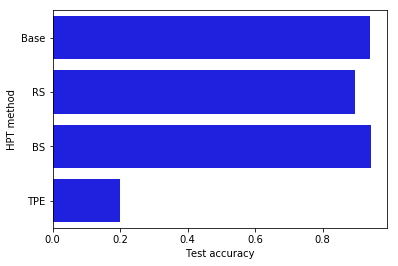

In [127]:
sns.barplot(x=TEST_ACC, y=HPT_METHOD, data =df, color='b')

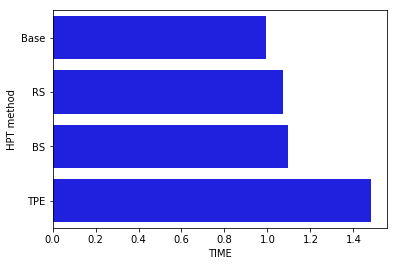

In [105]:
sns.barplot(x='TIME', y=HPT_METHOD, data =df, color='b')

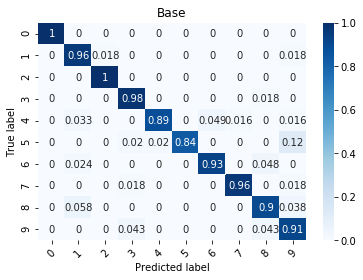

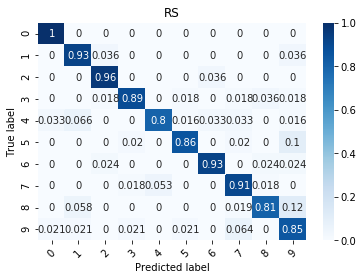

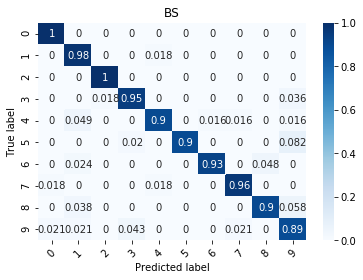

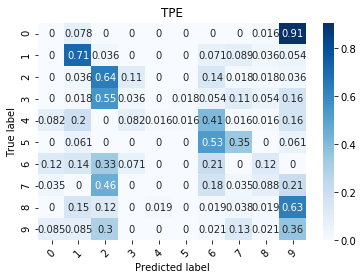

In [129]:
for r in res:
    plot_confusion_matrix(r[CONF_MATRIX], classes=dsBunch.target_names, title=r[HPT_METHOD])


In [211]:
hls = [(100,)*10, (n_features,)*10, (100,)*5, (n_features,)*5]
alpha = [0.0001, 0.001, 0.01, 0.1, 1]

pg = {
    'hidden_layer_sizes': hls,
    'alpha': alpha
}
hg={
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes',hls),
    'alpha': hp.choice('alpha', alpha),
}

bg = {
    'hidden_layer_sizes': Categorical(hls),
    'alpha': Real(0.001, 1.0, 'loguniform'),
}
base = {'hidden_layer_sizes':(100,)*2, 'random_state':0}

In [212]:
# define MLPClassifier
m = mdl.load_MLPClassifier()
hpt_objs = [
        HPT_OBJ('Baseline', base, run_baseline, {}),
        HPT_OBJ('Grid Search', pg, grid_search, {}),
        HPT_OBJ('Random Search', pg, random_search, {'n_iter': MAX_ITER}),
        HPT_OBJ('Bayes Seach', bg, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Tree of Parzen Est.', hg, tpe_search, {})
]
loss='neg_log_loss'
#loss='accuracy'

mlpc ={
    'model': m.model,
    'hpt_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
}

In [213]:


res = cmp_hpt_methods(data, **mlpc)
#res

5 2


64
{'hidden_layer_sizes': (100, 100), 'random_state': 0}
-0.1382337218405239
-0.1382337218405239
64
{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100, 100, 100)}
-0.14138887429853808
-0.14138887429853808
64
{'alpha': 1, 'hidden_layer_sizes': (100, 100, 100, 100, 100)}
-0.13492602675886095
-0.13492602675886095
64
{'alpha': 1, 'hidden_layer_sizes': (64, 64, 64, 64, 64, 64, 64, 64, 64, 64)}
-0.19581859187199763
-0.19581859187199763
64
{'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 64, 64, 64)}
-0.15833555554054984
-0.15833555554054984
64
{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100)}
-0.16451041707633873
-0.16451041707633873



In [214]:
sum_res = []
for r in res:
    t = np.array(r[INNER_RES]['mean_fit_time']).mean()
    sum_res.append((r[HPT_METHOD], t, r[PARAMS_SAMPLED], r[TEST_ACC], r[BEST_PARAMS]))
                   
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS])

In [215]:
pd.DataFrame(res[1][INNER_RES])
df

,HPT method,TIME,Parameters sampled,Test accuracy,Best Parameters
0,Baseline,1.429046,11,0.966667,"{'hidden_layer_sizes': (100, 100), 'random_sta..."
1,Grid Search,4.018117,16,0.968519,"{'alpha': 0.0001, 'hidden_layer_sizes': (100, ..."
2,Random Search,4.992369,16,0.972222,"{'hidden_layer_sizes': (100, 100, 100, 100, 10..."
3,Bayes Seach,4.627524,12,0.968519,"{'alpha': 0.3281595493712576, 'hidden_layer_si..."
4,Tree of Parzen Est.,3.740687,11,0.975926,"{'alpha': 1, 'hidden_layer_sizes': (100, 100, ..."


In [221]:
df[BEST_PARAMS]

0    {'hidden_layer_sizes': (100, 100), 'random_sta...
1    {'alpha': 0.0001, 'hidden_layer_sizes': (100, ...
2    {'hidden_layer_sizes': (100, 100, 100, 100, 10...
3    {'alpha': 0.3281595493712576, 'hidden_layer_si...
4    {'alpha': 1, 'hidden_layer_sizes': (100, 100, ...
Name: Best Parameters, dtype: object

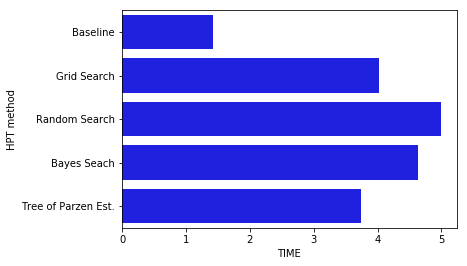

In [223]:
sns.barplot(x='TIME', y=HPT_METHOD,data =df, color='b')

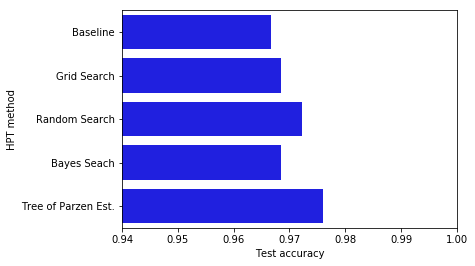

In [218]:
fig, ax =plt.subplots()
ax.set(xlim=(0.94, 1.0))
sns.barplot(x=TEST_ACC, y=HPT_METHOD, ax = ax,data =df, color='b')
#plt.show()

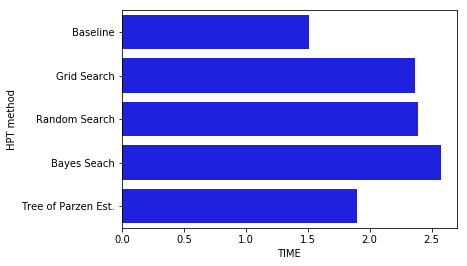

In [194]:
plt.figure()
sns.barplot(x='TIME', y=HPT_METHOD, data =df, color='b')

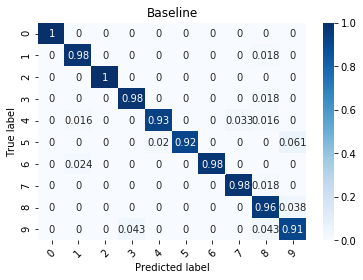

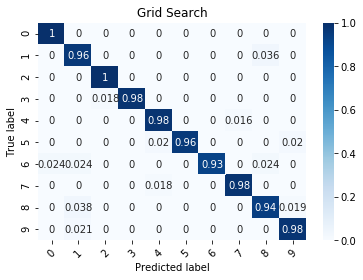

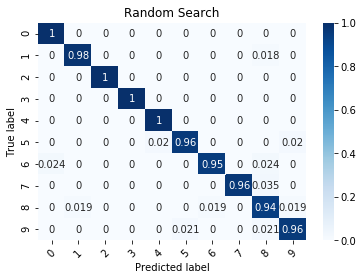

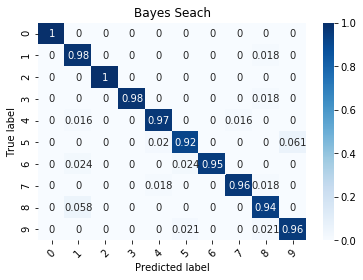

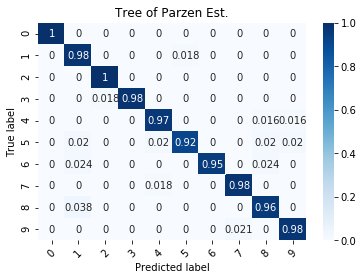

In [185]:
for r in res:
    plot_confusion_matrix(r[CONF_MATRIX], classes=dsBunch.target_names, title=r[HPT_METHOD])


In [182]:
for i in range(5):
    res = cmp_hpt_methods(ds, **mlpc)
    for r in res:
        print(r['method'])
        print(r['best_params'])
        plot_confusion_matrix(r['conf_matrix'], classes=dsBunch.target_names, title=r['method'])

        

TypeError: 'module' object is not iterable

In [ ]:
methods = []
dfs = {}

for data in res:
    methods.append(data['method'])
    dfs[data['method']]=(pd.DataFrame(data['data']))
df = pd.DataFrame(res[2]['data']).sort_values(by=['mean_test_score'], ascending=False)
l = [i for i in range(len(df.index))]
print(l)
df.set_index([l, 'mean_test_score'])

# i =np.argmax()
# res[1]['data']['params'][i]


In [ ]:
dfs[methods[-1]].drop(['loss', 'status'], 1)
dfs[methods[-1]]

In [ ]:
n = 'name'
mts = 'mean_test_score'
mft = 'mean_fit_time'
all_df = pd.DataFrame(columns=[n, mts, mft, 'params_sampled'])
for i, m in enumerate(methods[1:4]):
    all_df.loc[i] = [m, dfs[m][mts].mean(), dfs[m][mft].mean(),len(dfs[m].index)]
all_df

In [ ]:
sns.barplot(x=mts, y=n, data=all_df, color='m')


In [ ]:
conf_m = [[497, 52],[108, 234]]
conf_m = np.array(conf_m)
normalised = conf_m.astype('float')/ conf_m.sum(axis=1)[:,np.newaxis]

In [ ]:
r = []
for i in res:
    r.append(i['conf_matrix'])
    plot_confusion_matrix(i['conf_matrix'], classes=irisBunch.target_names, title=i['method'])


In [ ]:
# plot confusion matrix 

sns.heatmap(normalised, annot=True,annot_kws={"size": 16}, cmap=plt.cm.Blues)

In [ ]:
sns.barplot(x=(('params_sampled')), y=n, data=all_df)

In [ ]:
sns.barplot(x=mft, y=n, data=all_df, color='m')

In [ ]:
# define SVC
m = mdl.load_SVC()
hpt_objs = [
        HPT_OBJ('Baseline', m.base, run_baseline, {}),
        HPT_OBJ('Grid Search', m.param_grid, grid_search, {}),
        HPT_OBJ('Random Search', m.param_grid, random_search, {'n_iter': MAX_ITER}),
        HPT_OBJ('Bayes Seach', m.bayes_grid, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Tree of Parzen Est.', m.hyperopt_grid, tpe_search, {})
]
loss=None

models_targs.append({
    'model': m.model,
    'htp_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
})

In [ ]:
# define SVC
m = mdl.load_RandomForestClassifier()
hpt_objs = [
        HPT_OBJ('Baseline', m.base, run_baseline, {}),
        HPT_OBJ('Grid Search', m.param_grid, grid_search, {}),
        HPT_OBJ('Random Search', m.param_grid, random_search, {'n_iter': MAX_ITER}),
       # HPT_OBJ('Bayes Seach', m.bayes_grid, baysian_search, {'n_iter':MAX_ITER}),
       # HPT_OBJ('Tree of Parzen Est.', m.hyperopt_grid, tpe_search, {})
]
loss=None

models_targs.append({
    'model': m.model,
    'htp_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
})

In [ ]:
# RUN TUNING
all_results = []

for m_args in models_targs:
    for name in datasets:
        d = datasets[name]
        try:
            result = cmp_hpt_methods(
                (d.data, d.target),
                **m_args,
                random_state=1,
                name=name
            )
            all_results.append(result)
        except Exception as e:
            print('!!!!!!!!!!!!!!!!!!')
            print(m.model.__name__,name)
            print(e)


In [ ]:
len(all_results)

In [ ]:
 
table_by_ds(all_results[0:4], ds_names)

In [ ]:
for x in [MEAN+CV_TIME, MEAN+TEST_ACC]:
    plot_by_ds(x, all_results[0:4], ds_names)
    plot_by_ds(x, all_results[4:8], ds_names)
    #plot_by_ds(x, all_results[8:12], ds_names)

In [ ]:
pd.DataFrame(all_results[0])